<a href="https://colab.research.google.com/github/positivezenart/Deep-learning/blob/main/Final_of_CNN_on_CIFR_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from matplotlib import pyplot

In [ ]:
import tensorflow as tf

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun  3 04:58:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
def normalize_pixels(train, test):
    '''
    Normalize data into range of 0 to 1
    '''
    train_norm = train.astype('float32')
    test_norm  = test.astype('float32')
    
    train_norm /= 255
    test_norm /= 255
    
    return (train_norm, test_norm)

In [ ]:
X_train,X_test=normalize_pixels(X_train,X_test)

In [ ]:
sample_image=X_train[4]
sample_image.shape

(32, 32, 3)

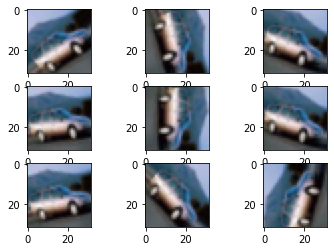

In [ ]:
sample_images = expand_dims(sample_image, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(sample_images, batch_size=1)
# generate sample images and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    image = batch[0];
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

In [ ]:
def model_summarize(history):
    '''
    Summarize model i.e. print train and test loss
    '''
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy


In [ ]:
# plot diagnostic learning curves
def model_summarize(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file	
	pyplot.show()


In [ ]:
def model_harness(X_train, y_train, X_test, y_test, given_batch_size, given_epochs):
    '''
    define model using data augmentation technique and extend it to it's vertical limit
    '''    
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    iterator_train = datagen.flow(X_train, y_train, batch_size=given_batch_size)
    # fit model    
    history = model.fit(iterator_train, epochs=given_epochs, validation_data=(X_test, y_test), verbose=1)
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))    
    model_summarize(history)

In [ ]:
def denseblock(input, num_filter = 64, dropout_rate = 0):
    '''
    Create dense block
    '''
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5),kernel_initializer="he_uniform" ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

def transition(input, num_filter = 32, dropout_rate = 0):
    '''
    Create transition block
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), kernel_initializer="he_uniform" ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    '''
    define output layer
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    
    return output

In [ ]:
num_filter = 10
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel))
First_Conv2D = layers.Conv2D(num_filter, (5,5), use_bias=False ,padding='same')(input)
BatchNorm = layers.BatchNormalization()(First_Conv2D)

First_Block = denseblock(BatchNorm,32, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, 16, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 10)   750         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 10)  40          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 10)  40          ['batch_normalization[0][0]']

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Epoch 1/70
782/782 [==============================] - 131s 144ms/step - loss: 1.6384 - accuracy: 0.3958 - val_loss: 1.6959 - val_accuracy: 0.4049
Epoch 2/70
782/782 [==============================] - 111s 142ms/step - loss: 1.2942 - accuracy: 0.5305 - val_loss: 1.1774 - val_accuracy: 0.5797
Epoch 3/70
782/782 [==============================] - 112s 144ms/step - loss: 1.1071 - accuracy: 0.6028 - val_loss: 1.1257 - val_accuracy: 0.6066
Epoch 4/70
782/782 [==============================] - 113s 144ms/step - loss: 0.9804 - accuracy: 0.6509 - val_loss: 0.9691 - val_accuracy: 0.6610
Epoch 5/70
782/782 [==============================] - 113s 144ms/step - loss: 0.8812 - accuracy: 0.6877 - val_loss: 1.0061 - val_accuracy: 0.6536
Epoch 6/70
782/782 [==============================] - 113s 144ms/step - loss: 0.8164 - accuracy: 0.7117 - val_loss: 0.8813 - val_accuracy: 0.6951
Epoch 7/70
782/782 [==============================] - 112s 143ms/step - loss: 0.7612 - accuracy: 0.7326 - val_loss: 0.8578 -

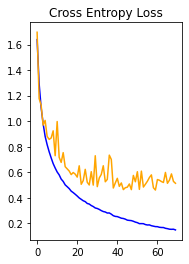

In [ ]:
model_harness(X_train, y_train, X_test, y_test, 64 ,70)

**Task**:**Model without Dense layer**

In [ ]:
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    '''
    Create Dense Block
    '''
    global compression
    temp = input
    for _ in range(l): 
        
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
            
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

def transition(input, num_filter = 12, dropout_rate = 0.2):
    '''
    Create transition block
    '''
    global compression
    
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
            
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    '''
    Define output layer
    '''
    global compression
    
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers. MaxPooling2D(pool_size=(2,2))(relu)
    
    output = layers.Conv2D(filters=10,kernel_size=(2,2),activation='softmax')(AvgPooling)
   
    flat = layers.Flatten()(output)
    
    return flat

In [ ]:

num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D,10, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, 10, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)



In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 10)   750         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 10)  40          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 10)  40          ['batch_normalization[0][0]']

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


Epoch 1/100
834/834 [==============================] - 109s 107ms/step - loss: 1.6484 - accuracy: 0.3838 - val_loss: 1.5036 - val_accuracy: 0.4482
Epoch 2/100
834/834 [==============================] - 87s 104ms/step - loss: 1.3205 - accuracy: 0.5146 - val_loss: 1.9399 - val_accuracy: 0.4071
Epoch 3/100
834/834 [==============================] - 87s 104ms/step - loss: 1.1149 - accuracy: 0.5966 - val_loss: 1.0779 - val_accuracy: 0.6150
Epoch 4/100
834/834 [==============================] - 87s 104ms/step - loss: 0.9740 - accuracy: 0.6503 - val_loss: 1.5101 - val_accuracy: 0.5317
Epoch 5/100
834/834 [==============================] - 87s 104ms/step - loss: 0.8838 - accuracy: 0.6843 - val_loss: 0.9649 - val_accuracy: 0.6623
Epoch 6/100
834/834 [==============================] - 87s 104ms/step - loss: 0.8150 - accuracy: 0.7104 - val_loss: 0.9131 - val_accuracy: 0.6897
Epoch 7/100
834/834 [==============================] - 87s 104ms/step - loss: 0.7584 - accuracy: 0.7335 - val_loss: 0.8974 

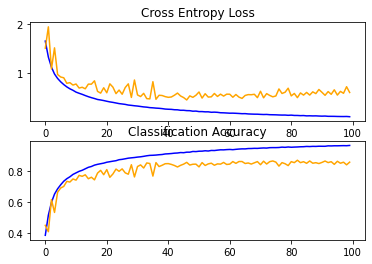

In [ ]:
# sample run
model_harness(X_train, y_train, X_test, y_test, 60,100)


In [ ]:
model.save_weights("DNST_model_without_dense_layer.h5")
print("Saved model to disk")

Saved model to disk


Epoch 1/50
834/834 [==============================] - 87s 104ms/step - loss: 0.1004 - accuracy: 0.9643 - val_loss: 0.5539 - val_accuracy: 0.8662
Epoch 2/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0986 - accuracy: 0.9657 - val_loss: 0.6537 - val_accuracy: 0.8483
Epoch 3/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0989 - accuracy: 0.9654 - val_loss: 0.5978 - val_accuracy: 0.8580
Epoch 4/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0973 - accuracy: 0.9657 - val_loss: 0.5604 - val_accuracy: 0.8642
Epoch 5/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0924 - accuracy: 0.9668 - val_loss: 0.6893 - val_accuracy: 0.8447
Epoch 6/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0949 - accuracy: 0.9672 - val_loss: 0.6527 - val_accuracy: 0.8491
Epoch 7/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0946 - accuracy: 0.9672 - val_loss: 0.6579 - val_ac

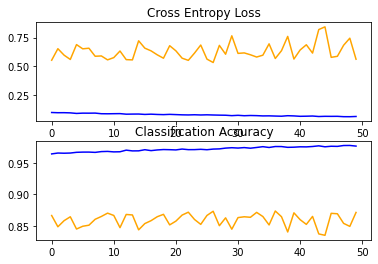

In [ ]:
model_harness(X_train, y_train, X_test, y_test, 60,50)

In [ ]:
model.save_weights("DNST_model_without_dense_layer.h5")
print("Saved model to disk")

Saved model to disk


Epoch 1/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0622 - accuracy: 0.9782 - val_loss: 0.6337 - val_accuracy: 0.8611
Epoch 2/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0639 - accuracy: 0.9770 - val_loss: 0.5686 - val_accuracy: 0.8732
Epoch 3/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0618 - accuracy: 0.9781 - val_loss: 0.6218 - val_accuracy: 0.8657
Epoch 4/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0636 - accuracy: 0.9777 - val_loss: 0.6405 - val_accuracy: 0.8638
Epoch 5/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0630 - accuracy: 0.9774 - val_loss: 0.6376 - val_accuracy: 0.8646
Epoch 6/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0599 - accuracy: 0.9791 - val_loss: 0.8150 - val_accuracy: 0.8421
Epoch 7/50
834/834 [==============================] - 87s 104ms/step - loss: 0.0638 - accuracy: 0.9765 - val_loss: 0.7522 - val_ac

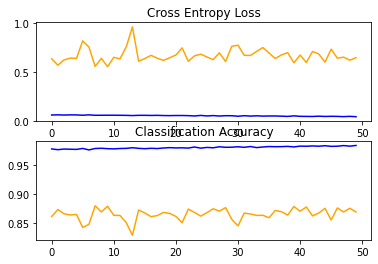

In [ ]:
model_harness(X_train, y_train, X_test, y_test, 60,50)

In [ ]:
model.save_weights("DNST_model_without_dense_layer.h5")
print("Saved model to disk")

Saved model to disk


Epoch 1/100
834/834 [==============================] - 88s 105ms/step - loss: 0.0495 - accuracy: 0.9826 - val_loss: 0.6125 - val_accuracy: 0.8787
Epoch 2/100
834/834 [==============================] - 87s 104ms/step - loss: 0.0467 - accuracy: 0.9845 - val_loss: 0.6205 - val_accuracy: 0.8748
Epoch 3/100
834/834 [==============================] - 87s 104ms/step - loss: 0.0482 - accuracy: 0.9835 - val_loss: 0.7046 - val_accuracy: 0.8613
Epoch 4/100
834/834 [==============================] - 87s 104ms/step - loss: 0.0455 - accuracy: 0.9842 - val_loss: 0.6141 - val_accuracy: 0.8754
Epoch 5/100
834/834 [==============================] - 87s 104ms/step - loss: 0.0475 - accuracy: 0.9830 - val_loss: 0.6321 - val_accuracy: 0.8726
Epoch 6/100
834/834 [==============================] - 87s 104ms/step - loss: 0.0429 - accuracy: 0.9847 - val_loss: 0.6802 - val_accuracy: 0.8687
Epoch 7/100
834/834 [==============================] - 87s 104ms/step - loss: 0.0489 - accuracy: 0.9831 - val_loss: 0.6084 -

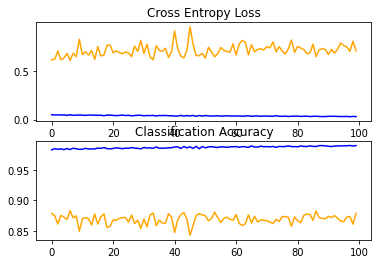

In [ ]:
model_harness(X_train, y_train, X_test, y_test, 60,100)

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Model', 'Epochs', 'Train Accuracy', 'Test Accuracy']
table.add_row(['With dense layer ', 70, 0.9471, 0.8631])
table.add_row(['Without dense layer', '300', 0.9896,  0.8789])
print(table)

+---------------------+--------+----------------+---------------+
|        Model        | Epochs | Train Accuracy | Test Accuracy |
+---------------------+--------+----------------+---------------+
|  With dense layer   |   75   |     0.9478     |     0.8603    |
| Without dense layer |  300   |     0.9896     |     0.8789    |
+---------------------+--------+----------------+---------------+


Reference links:
1. https://towardsdatascience.com/paper-review-densenet-densely-connected-convolutional-networks-acf9065dfefb
2.#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
3. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
4.https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator